https://www.kaggle.com/datasets/renjiabarai/malware-attacks/data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("attacks.csv")
pd.set_option("Display.max_columns", None)
df1 = df.copy()

In [6]:
df.head()

,src_ipv4,src_ipv6,src_mac,src_port,dest_port,duration,os,packet_size,tcp,udp,http,https,ssh,smtp,pop3,ftp,icmp,syn,ack,fin,psh,urg,ece,cwr,attack_type
0,144.46.175.132,cb5c:4734:5940:541f:9922:18b9:bacc:d288,81:48:99:10:80:c4,42199,41731,973309,windows,27977,f,t,f,t,f,t,f,t,f,t,f,f,t,f,f,f,DoS
1,218.156.185.187,94bb:5302:ce9a:ad29:d730:f895:c423:a935,4c:0c:56:13:35:dd,22773,21570,879523,macos,130825,f,t,t,t,t,f,t,f,f,f,t,f,t,f,t,f,Phishing
2,147.225.24.241,5886:8686:ad33:c5f2:d0a9:458:25e6:8f7b,56:8c:58:ae:54:3f,29656,16287,122040,windows,555253,t,t,f,t,t,t,f,t,t,f,t,f,f,f,f,t,DDoS
3,205.44.151.19,6d8a:cca0:b22a:13ea:5ace:162d:190d:f184,fa:4d:a4:fa:e6:1f,21294,42000,57818,chrome os,930746,t,f,f,f,t,t,t,f,t,t,t,t,t,f,f,t,Phishing
4,150.158.113.97,f044:b945:4a93:1aee:67ae:2628:a82a:de17,d0:5f:1c:6f:ba:46,16425,6092,14124,windows,882800,t,t,t,f,t,f,t,f,f,t,f,t,f,f,t,f,DoS


In [8]:
df.isnull().sum()

src_ipv4       0
src_ipv6       0
src_mac        0
src_port       0
dest_port      0
duration       0
os             0
packet_size    0
tcp            0
udp            0
http           0
https          0
ssh            0
smtp           0
pop3           0
ftp            0
icmp           0
syn            0
ack            0
fin            0
psh            0
urg            0
ece            0
cwr            0
attack_type    0
dtype: int64

In [10]:
df.drop(columns = ["src_mac", "src_port", "dest_port"], inplace = True)

In [12]:
for col in df.drop(columns = ["os", "attack_type"]).columns.to_list():
    if df[col].dtype == "object":
        df[col] = df[col].map({"t" : 1, "f" : 0})

In [13]:
df.head()

,src_ipv4,src_ipv6,duration,os,packet_size,tcp,udp,http,https,ssh,smtp,pop3,ftp,icmp,syn,ack,fin,psh,urg,ece,cwr,attack_type
0,NaN,NaN,973309,windows,27977,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,DoS
1,NaN,NaN,879523,macos,130825,0,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,Phishing
2,NaN,NaN,122040,windows,555253,1,1,0,1,1,1,0,1,1,0,1,0,0,0,0,1,DDoS
3,NaN,NaN,57818,chrome os,930746,1,0,0,0,1,1,1,0,1,1,1,1,1,0,0,1,Phishing
4,NaN,NaN,14124,windows,882800,1,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,DoS


In [16]:
df.drop(columns = ["src_ipv4", "src_ipv6"], inplace = True)

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import optuna

In [20]:
df["attack_type"] = df1["attack_type"]
df["attack_type"] = df["attack_type"].map({"DDoS" : 0, "DoS" : 1, "Phishing" : 2, "Recon" : 3, "Mirai" : 4})

In [22]:
#df = pd.get_dummies(df.drop("attack_type", axis = 1), drop_first = True)
#for col in df.columns.to_list():
    #if df[col].dtype == "bool":
        #df[col] = df[col].map({True : 1, False : 0})
X = df.drop("attack_type", axis = 1)
y = df["attack_type"]

In [24]:
X = pd.get_dummies(X, drop_first = True)
for col in X.columns.to_list():
    if X[col].dtype == "bool":
        X[col] = X[col].map({True : 1, False : 0})

In [26]:
X

,duration,packet_size,tcp,udp,http,https,ssh,smtp,pop3,ftp,icmp,syn,ack,fin,psh,urg,ece,cwr,os_linux,os_macos,os_other,os_windows
0,973309,27977,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1
1,879523,130825,0,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0
2,122040,555253,1,1,0,1,1,1,0,1,1,0,1,0,0,0,0,1,0,0,0,1
3,57818,930746,1,0,0,0,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,0
4,14124,882800,1,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,517282,20403,0,1,1,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1,0
799996,425794,283475,1,1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,1
799997,353583,200431,1,1,1,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1
799998,577832,715486,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [30]:
from xgboost import XGBClassifier
def objective(trial):
    param_grid = {
        "max_depth" : trial.suggest_int("max_depth", 1, 20),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-3, 1.0, log = True),
        "n_estimators" : trial.suggest_int("n_estimators", 100, 200),
        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 10),
        "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree" : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }

    model = XGBClassifier(**param_grid, use_label_encoder = False)
    model.fit(X_train, y_train)
    return f1_score(y_test, model.predict(X_test), average = None)

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-07-18 11:22:35,416] A new study created in memory with name: no-name-57b0327c-7291-45b1-b701-46c229d03943
E:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[W 2024-07-18 11:23:20,829] Trial 0 failed with parameters: {'max_depth': 15, 'learning_rate': 0.11478944285946999, 'n_estimators': 150, 'min_child_weight': 9, 'subsample': 0.6658076570416191, 'colsample_bytree': 0.593995657737101, 'gamma': 3.4933537729193936e-06, 'reg_alpha': 1.0528570208054238e-06, 'reg_lambda': 0.1513799167283683} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^

KeyboardInterrupt: 

In [34]:
y.value_counts()

attack_type
0    160770
3    160115
1    160030
2    159668
4    159417
Name: count, dtype: int64

In [46]:
model = XGBClassifier(n_jobs = -1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: >

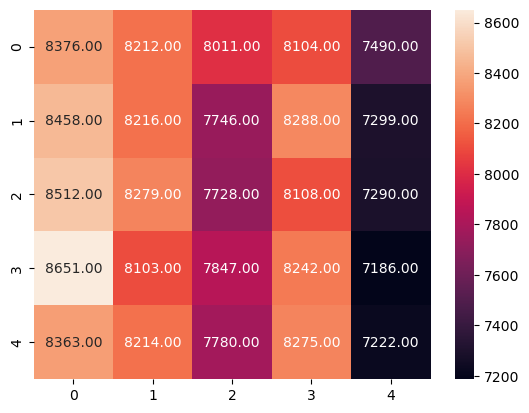

In [48]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot = True, fmt = ".2f")

In [36]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators = 200)
abc.fit(X_train, y_train)

E:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=200)

<Axes: >

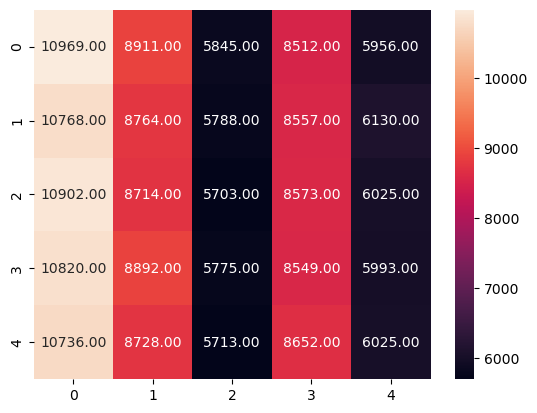

In [40]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, abc.predict(X_test)), annot = True, fmt = ".2f")

In [77]:
df.shape

(800000, 20)

In [46]:
X_traina = X_train.copy()
X_testa = X_test.copy()

In [48]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()
X_traina[["packet_size", "duration"]] = st.fit_transform(X_traina[["packet_size", "duration"]])
X_testa[["packet_size", "duration"]] = st.transform(X_testa[["packet_size", "duration"]])

In [50]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = "saga", n_jobs = -1, multi_class = "multinomial")
lr.fit(X_traina, y_train)

LogisticRegression(multi_class='multinomial', n_jobs=-1, solver='saga')

<Axes: >

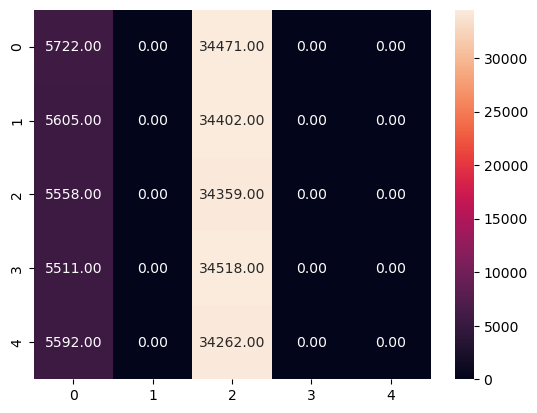

In [52]:
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test)), annot = True, fmt = ".2f")

In [147]:
from sklearn.ensemble import GradientBoostingClassifier
gbr = GradientBoostingClassifier(n_estimators = 50)
gbr.fit(Xb, yb)

E:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GradientBoostingClassifier(n_estimators=50)

<Axes: >

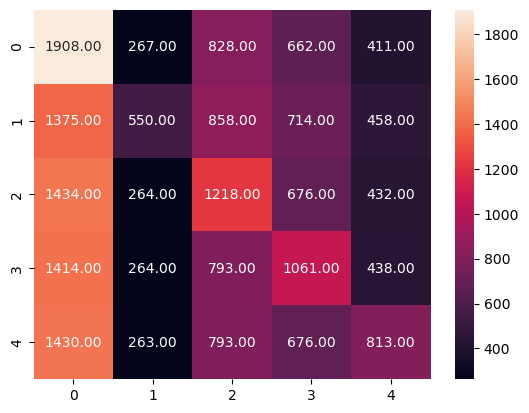

In [151]:
sns.heatmap(confusion_matrix(yb, gbr.predict(Xb)), annot = True, fmt = ".2f")

In [107]:
df_half = df.iloc[0 : 20000, :-1]

In [111]:
df_half = pd.get_dummies(df_half, drop_first = True)

In [119]:
Xb = df_half

In [121]:
Xb

,duration,packet_size,tcp,udp,http,https,ssh,smtp,pop3,ftp,icmp,syn,ack,fin,psh,urg,ece,cwr,os_linux,os_macos,os_other,os_windows
0,973309,27977,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,False,False,False,True
1,879523,130825,0,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,False,True,False,False
2,122040,555253,1,1,0,1,1,1,0,1,1,0,1,0,0,0,0,1,False,False,False,True
3,57818,930746,1,0,0,0,1,1,1,0,1,1,1,1,1,0,0,1,False,False,False,False
4,14124,882800,1,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,325094,351811,0,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,False,True,False,False
19996,24642,708590,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,False,True,False,False
19997,316311,116173,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,1,False,False,False,True
19998,761947,651810,1,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,False,False,False,True


In [125]:
for col in Xb.columns.to_list():
    if Xb[col].dtype == "bool":
        Xb[col] = Xb[col].map({True : 1, False : 0})

In [139]:
yb = df.iloc[0: 20000, 19]

In [141]:
yb

0        1
1        2
2        0
3        2
4        1
        ..
19995    4
19996    0
19997    2
19998    2
19999    0
Name: attack_type, Length: 20000, dtype: int64

In [155]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train)

HistGradientBoostingClassifier()

<Axes: >

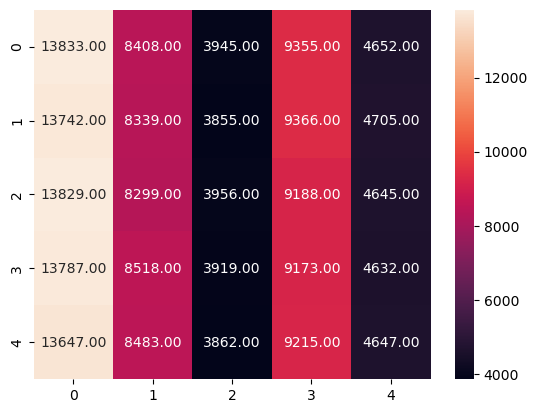

In [157]:
sns.heatmap(confusion_matrix(y_test, hgbc.predict(X_test)), annot = True, fmt = ".2f")